## Data Loading and Import Library

In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [102]:
df = pd.read_csv('data.csv',)
df['ds'] = pd.to_datetime(df['ds'])



## Data Splitting

- **Data Splitting:** The data is split into training and testing sets based on the date. Data points with dates on or before '2023-11-30' are assigned to the training set, while data points with dates after '2023-11-30' are assigned to the testing set.



In [103]:
train = df[df['ds'] <= '2023-11-30']
test = df[df['ds'] > '2023-11-30']

train

,ds,y
0,2023-01-01,658
1,2023-01-02,659
2,2023-01-03,664
3,2023-01-04,772
4,2023-01-05,858
...,...,...
312,2023-11-25,984
313,2023-11-26,594
314,2023-11-28,630
315,2023-11-29,698


##Data set Visualization

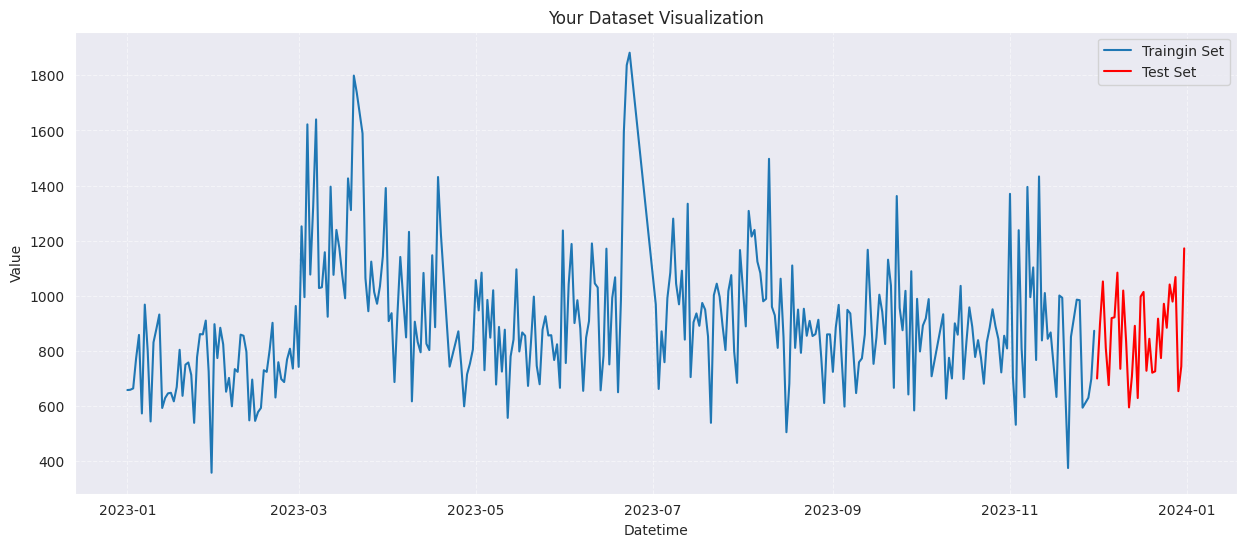

In [104]:
plt.figure(figsize=(15, 6))
plt.plot(train["ds"], train["y"], label="Traingin Set")
plt.plot(test["ds"], test["y"], color='red', label="Test Set")

# Improve visualization
plt.xlabel("Datetime")
plt.ylabel("Value")
plt.title("Your Dataset Visualization")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)

### Data Distribution Analysis

Visualizations represent the distribution of the training dataset

Text(0, 0.5, 'Density')

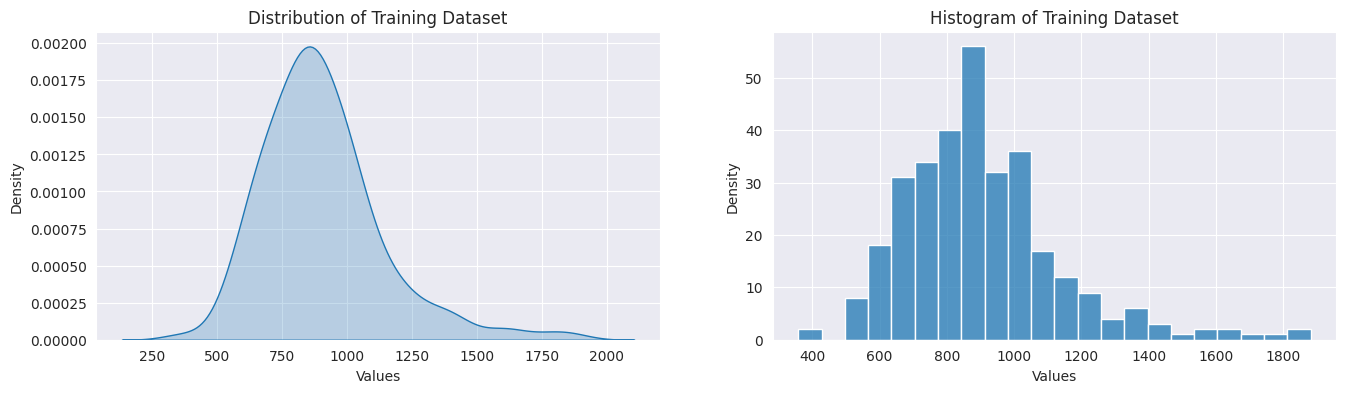

In [105]:

fig, axes = plt.subplots(1,2,  figsize=(16, 4))  # 3 rows, 2 columns


sns.kdeplot(train['y'], fill=True, ax=axes[0])
axes[0].set_title('Distribution of Training Dataset')
axes[0].set_xlabel('Values')
axes[0].set_ylabel('Density')

# Plot the histplot on the second subplot
# Access the correct Axes object using indexing
sns.histplot(train['y'], ax=axes[1])
axes[ 1].set_title('Histogram of Training Dataset')
axes[ 1].set_xlabel('Values')
axes[ 1].set_ylabel('Density')

### ACF and PACF Analysis

- **Autocorrelation Function (ACF)**: Shows how current values relate to past values at different lags.
- **Partial Autocorrelation Function (PACF)**: Helps identify the direct effect of a lag on the current value
- Useful for determining AR and MA terms in ARIMA modeling.


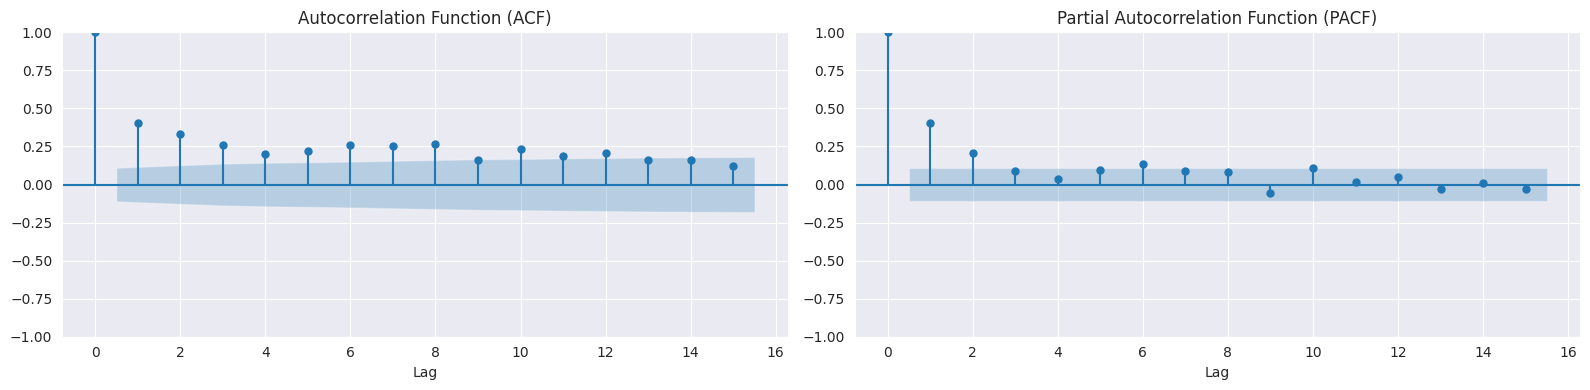

In [106]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1, 2, figsize=(16, 4))

# ACF Plot
plot_acf(train['y'], ax=axes[0], lags=15)
axes[0].set_title("Autocorrelation Function (ACF)")
axes[0].set_xlabel("Lag")


# PACF Plot
plot_pacf(train['y'], ax=axes[1], lags=15)
axes[1].set_title("Partial Autocorrelation Function (PACF)")
axes[1].set_xlabel("Lag")

plt.tight_layout()
plt.show()

### ARIMA Model Selection

- **Purpose**: Iterates over different ARIMA (p,d,q) parameters to find the best model based on the Akaike Information Criterion (AIC).
- **AIC Metric**: Lower values indicate a better-fitting model.

In [107]:
import warnings
warnings.filterwarnings("ignore")

ar = [1,2]
ma = [3]
di = [0,1]

best_aic = float('inf')
best_params = None

for p in ar:
  for d in di:
    for q in ma:
      model = ARIMA(train['y'], order=(p, d, q))
      model_fit = model.fit()
      print(f'ARIMA({p},{d},{q}) - AIC: {model_fit.aic}')
      if model_fit.aic < best_aic:
        best_aic = model_fit.aic
        best_params = (p, d, q)

ARIMA(1,0,3) - AIC: 4290.979987857514
ARIMA(1,1,3) - AIC: 4282.453179329876
ARIMA(2,0,3) - AIC: 4292.932141295967
ARIMA(2,1,3) - AIC: 4275.642890680546


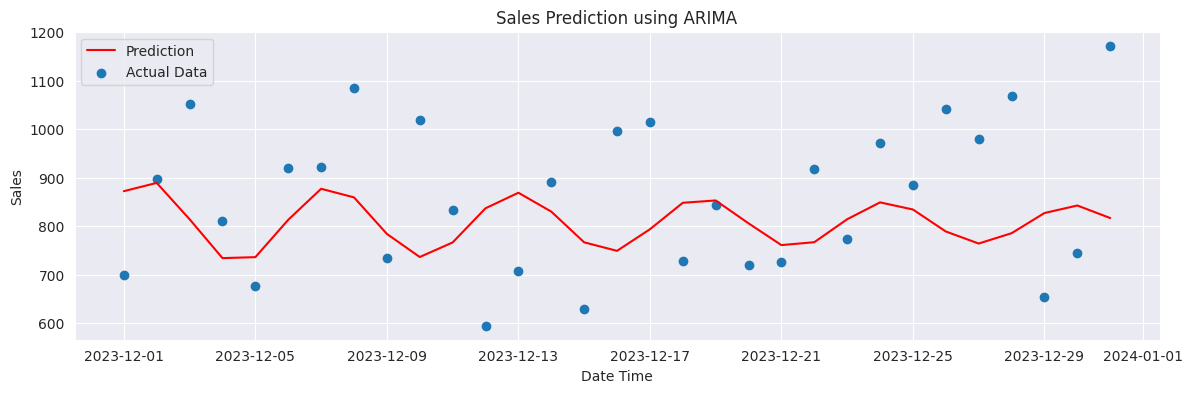

In [108]:
arima_model = ARIMA(train['y'], order=(best_params))
model_fit = arima_model.fit()
arima_pred = model_fit.forecast(len(test))


plt.figure(figsize=(14,4))
plt.plot(test['ds'],arima_pred,label='Prediction',color='red')
plt.scatter(test['ds'],test['y'],label='Actual Data')
plt.title('Sales Prediction using ARIMA')
plt.xlabel('Date Time')
plt.ylabel('Sales')
plt.legend()

#**Fit Prophet Model**

In [109]:
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import itertools

# Extended hyperparameter grid
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.03, 0.1],
    'seasonality_prior_scale': [0.01, 0.03, 0.05,0.08,0.1 ],
}


# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # To store the RMSE for each parameter combination

# Loop over each set of parameters
for params in all_params:
    #print("Evaluating parameters:", params)
    model = Prophet(**params)
    model.fit(train[["ds", "y"]])

    # Use cross-validation with:
    #   - initial: first 200 days for training
    #   - horizon: 31 days (matching your test set)
    #   - period: new fold every 31 days
    df_cv = cross_validation(model, initial='200 days', period='31 days', horizon='31 days')
    df_p = performance_metrics(df_cv, rolling_window=1)

    # Compute the mean RMSE from the folds
    rmse = df_p['rmse'].mean()
    rmses.append(rmse)
    #print(f"Parameters: {params} => RMSE: {rmse}\n")

# Identify the best hyperparameters (with the lowest RMSE)
best_params = all_params[rmses.index(min(rmses))]
print("Best parameters found:", best_params)

# Refit the model on the full training set using the best hyperparameters
best_model = Prophet(**best_params)
best_model.fit(train[["ds", "y"]])

# Predict on the test set
fb_pred = best_model.predict(test)


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpladijscc/chch_wrx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpladijscc/74m3ncnj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33345', 'data', 'file=/tmp/tmpladijscc/chch_wrx.json', 'init=/tmp/tmpladijscc/74m3ncnj.json', 'output', 'file=/tmp/tmpladijscc/prophet_modelooohx1pz/prophet_model-20250306132353.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:23:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cut

  0%|          | 0/4 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpladijscc/p7jq8xu6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpladijscc/qr6fz9ha.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19797', 'data', 'file=/tmp/tmpladijscc/p7jq8xu6.json', 'init=/tmp/tmpladijscc/qr6fz9ha.json', 'output', 'file=/tmp/tmpladijscc/prophet_modelfextvtlp/prophet_model-20250306132353.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:23:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
13:23:53 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpladijscc/86vfaxo_.json
DE

  0%|          | 0/4 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpladijscc/jcvdtn23.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpladijscc/g85j9s13.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65471', 'data', 'file=/tmp/tmpladijscc/jcvdtn23.json', 'init=/tmp/tmpladijscc/g85j9s13.json', 'output', 'file=/tmp/tmpladijscc/prophet_modelnhmz9cl3/prophet_model-20250306132354.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:23:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
13:23:54 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpladijscc/y1ve2pzd.json
DE

  0%|          | 0/4 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpladijscc/j9q2adal.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpladijscc/4htot_he.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6326', 'data', 'file=/tmp/tmpladijscc/j9q2adal.json', 'init=/tmp/tmpladijscc/4htot_he.json', 'output', 'file=/tmp/tmpladijscc/prophet_modelxer1fdap/prophet_model-20250306132356.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:23:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
13:23:56 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpladijscc/d5ou7142.json
DEB

  0%|          | 0/4 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpladijscc/q3t1jf7k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpladijscc/v4r_ev4s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81004', 'data', 'file=/tmp/tmpladijscc/q3t1jf7k.json', 'init=/tmp/tmpladijscc/v4r_ev4s.json', 'output', 'file=/tmp/tmpladijscc/prophet_modelzongsn4d/prophet_model-20250306132359.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:23:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
13:23:59 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpladijscc/v9is3jcd.json
DE

  0%|          | 0/4 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpladijscc/gzga5zge.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpladijscc/hvab_wjd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24548', 'data', 'file=/tmp/tmpladijscc/gzga5zge.json', 'init=/tmp/tmpladijscc/hvab_wjd.json', 'output', 'file=/tmp/tmpladijscc/prophet_model7j7kqb6s/prophet_model-20250306132400.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:24:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
13:24:00 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpladijscc/7jvzn5vf.json
DE

  0%|          | 0/4 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpladijscc/riwiaspp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpladijscc/im58qg5p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45960', 'data', 'file=/tmp/tmpladijscc/riwiaspp.json', 'init=/tmp/tmpladijscc/im58qg5p.json', 'output', 'file=/tmp/tmpladijscc/prophet_modelhpwtwnst/prophet_model-20250306132402.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:24:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpladijscc/drg7q36j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpladijscc/h_vko8jp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/4 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpladijscc/rzmiql_e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpladijscc/_jygwf3h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89882', 'data', 'file=/tmp/tmpladijscc/rzmiql_e.json', 'init=/tmp/tmpladijscc/_jygwf3h.json', 'output', 'file=/tmp/tmpladijscc/prophet_modelvz5gkmfl/prophet_model-20250306132402.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:24:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpladijscc/37o1y54l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpladijscc/iwh9i953.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/4 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpladijscc/7_0zs86a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpladijscc/ortjigu8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3192', 'data', 'file=/tmp/tmpladijscc/7_0zs86a.json', 'init=/tmp/tmpladijscc/ortjigu8.json', 'output', 'file=/tmp/tmpladijscc/prophet_modeljyjouql4/prophet_model-20250306132403.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:24:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpladijscc/zmq4jgnl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpladijscc/h2pkhbql.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

  0%|          | 0/4 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpladijscc/y5a5a45d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpladijscc/uce3xluh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79846', 'data', 'file=/tmp/tmpladijscc/y5a5a45d.json', 'init=/tmp/tmpladijscc/uce3xluh.json', 'output', 'file=/tmp/tmpladijscc/prophet_modelum9niel4/prophet_model-20250306132404.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:24:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpladijscc/4vsnex68.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpladijscc/yubodn6p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/4 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpladijscc/9729b4zc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpladijscc/xddhsbo5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59317', 'data', 'file=/tmp/tmpladijscc/9729b4zc.json', 'init=/tmp/tmpladijscc/xddhsbo5.json', 'output', 'file=/tmp/tmpladijscc/prophet_model764svb4x/prophet_model-20250306132404.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:24:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpladijscc/_uu4uu11.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpladijscc/88k8b_kl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/4 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpladijscc/uprzqxfw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpladijscc/48imjszg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22561', 'data', 'file=/tmp/tmpladijscc/uprzqxfw.json', 'init=/tmp/tmpladijscc/48imjszg.json', 'output', 'file=/tmp/tmpladijscc/prophet_modeliv_aycjb/prophet_model-20250306132405.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:24:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpladijscc/w9ppekig.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpladijscc/2pipe3_s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/4 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpladijscc/etbp1k3o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpladijscc/8tpsszrr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14679', 'data', 'file=/tmp/tmpladijscc/etbp1k3o.json', 'init=/tmp/tmpladijscc/8tpsszrr.json', 'output', 'file=/tmp/tmpladijscc/prophet_modelwcbrp9s8/prophet_model-20250306132406.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:24:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpladijscc/_cdcusbs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpladijscc/ddmyu1ty.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/4 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpladijscc/wp45rd22.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpladijscc/6ycg_nqe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69454', 'data', 'file=/tmp/tmpladijscc/wp45rd22.json', 'init=/tmp/tmpladijscc/6ycg_nqe.json', 'output', 'file=/tmp/tmpladijscc/prophet_modelfg5c72om/prophet_model-20250306132406.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:24:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpladijscc/_3n7m_k1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpladijscc/h4jyz3vl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/4 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpladijscc/9w_jba8e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpladijscc/5q6l01wa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9845', 'data', 'file=/tmp/tmpladijscc/9w_jba8e.json', 'init=/tmp/tmpladijscc/5q6l01wa.json', 'output', 'file=/tmp/tmpladijscc/prophet_model4a9cfjv4/prophet_model-20250306132407.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:24:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpladijscc/j5z15piy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpladijscc/1o4ujfdz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

  0%|          | 0/4 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpladijscc/czkqedhx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpladijscc/ky3swl8j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55928', 'data', 'file=/tmp/tmpladijscc/czkqedhx.json', 'init=/tmp/tmpladijscc/ky3swl8j.json', 'output', 'file=/tmp/tmpladijscc/prophet_model2al6cia2/prophet_model-20250306132408.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:24:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpladijscc/m9tas4t7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpladijscc/3yo748bu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/4 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpladijscc/mwcmxtkq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpladijscc/eikqg2od.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82542', 'data', 'file=/tmp/tmpladijscc/mwcmxtkq.json', 'init=/tmp/tmpladijscc/eikqg2od.json', 'output', 'file=/tmp/tmpladijscc/prophet_modelvln8kof3/prophet_model-20250306132409.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:24:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpladijscc/sugjtxlv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpladijscc/tqhugdvt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/4 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpladijscc/iau95r3f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpladijscc/3u4913di.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24170', 'data', 'file=/tmp/tmpladijscc/iau95r3f.json', 'init=/tmp/tmpladijscc/3u4913di.json', 'output', 'file=/tmp/tmpladijscc/prophet_modelxxfpfee8/prophet_model-20250306132409.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:24:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpladijscc/8geky4ck.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpladijscc/o6kht7nk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/4 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpladijscc/o12avpiw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpladijscc/ce5jaov3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45556', 'data', 'file=/tmp/tmpladijscc/o12avpiw.json', 'init=/tmp/tmpladijscc/ce5jaov3.json', 'output', 'file=/tmp/tmpladijscc/prophet_modelt00alunw/prophet_model-20250306132410.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:24:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpladijscc/8x1ur2nt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpladijscc/e6zmeowe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/4 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpladijscc/vb7qtd1i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpladijscc/t0q56jty.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43137', 'data', 'file=/tmp/tmpladijscc/vb7qtd1i.json', 'init=/tmp/tmpladijscc/t0q56jty.json', 'output', 'file=/tmp/tmpladijscc/prophet_modeldh8ntn6t/prophet_model-20250306132411.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:24:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpladijscc/k_ahy8uj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpladijscc/5j9t3smq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/4 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpladijscc/7_93fcd8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpladijscc/8tsrn6od.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77647', 'data', 'file=/tmp/tmpladijscc/7_93fcd8.json', 'init=/tmp/tmpladijscc/8tsrn6od.json', 'output', 'file=/tmp/tmpladijscc/prophet_modelqbvxy6xw/prophet_model-20250306132412.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:24:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpladijscc/001l0a21.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpladijscc/n4vcr3qh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Best parameters found: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.05}


In [110]:
best_params

{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.05}

#**Fit The LinearRegression Model**

In [111]:
from sklearn.linear_model import LinearRegression

data = df[['ds','y']].copy()

data["month"] = data["ds"].dt.month
data["day"] = data["ds"].dt.day
data["dayofweek"] = data["ds"].dt.dayofweek
data["dayofyear"] = data["ds"].dt.dayofyear
data["quarter"] = data["ds"].dt.quarter
data["weekofyear"] = data["ds"].dt.isocalendar().week

x_train = data[data["ds"] <= "2023-11-30"].drop(["ds", "y"], axis=1)
y_train = data[data["ds"] <= "2023-11-30"]["y"]

x_test = data[data["ds"] > "2023-11-30"].drop(["ds", "y"], axis=1)
y_test = data[data["ds"] > "2023-11-30"]["y"]


lr = LinearRegression()
lr.fit(x_train, y_train)
lr_pred = lr.predict(x_test)

data

,ds,y,month,day,dayofweek,dayofyear,quarter,weekofyear
0,2023-01-01,658,1,1,6,1,1,52
1,2023-01-02,659,1,2,0,2,1,1
2,2023-01-03,664,1,3,1,3,1,1
3,2023-01-04,772,1,4,2,4,1,1
4,2023-01-05,858,1,5,3,5,1,1
...,...,...,...,...,...,...,...,...
343,2023-12-27,979,12,27,2,361,4,52
344,2023-12-28,1068,12,28,3,362,4,52
345,2023-12-29,654,12,29,4,363,4,52
346,2023-12-30,744,12,30,5,364,4,52


## **Prediction Plot: ( Linear Regression, Prophet, and ARIMA )**

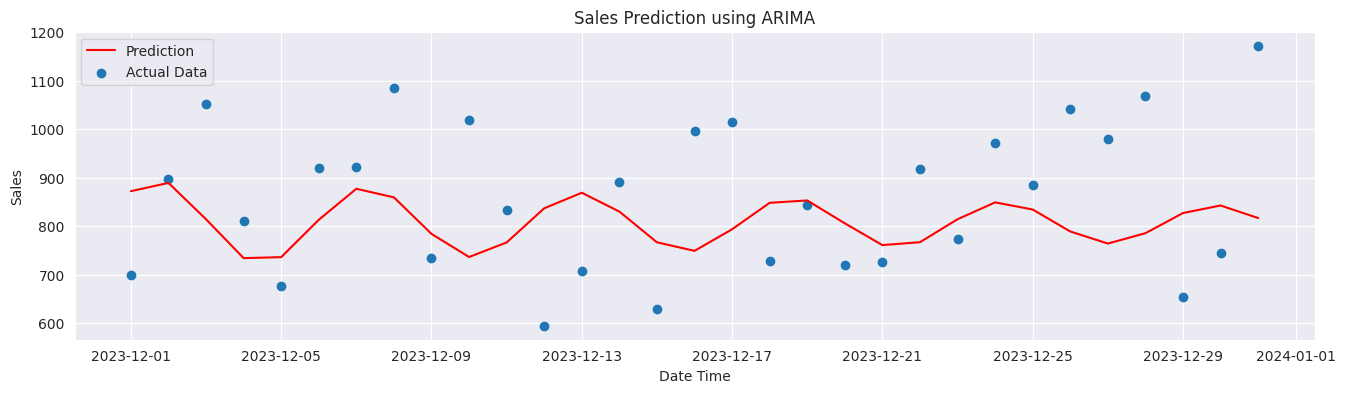

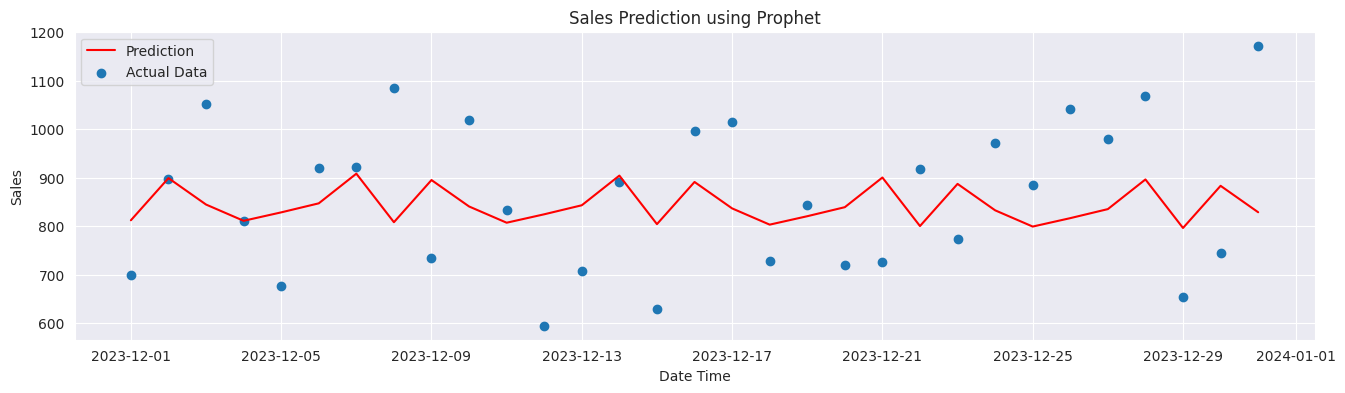

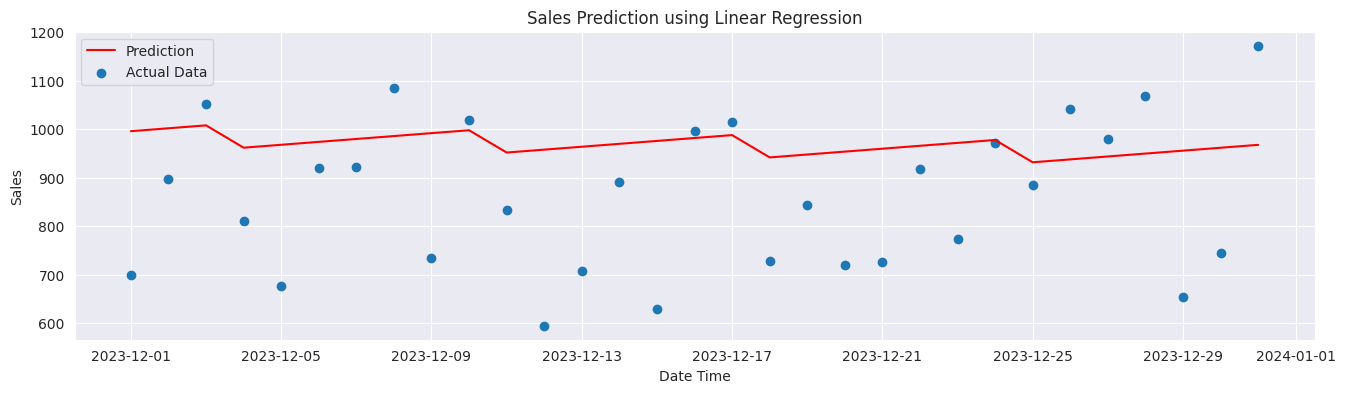

In [112]:
# plot ARIMA model Predictions
plt.figure(figsize=(16,4))
plt.plot(test['ds'],arima_pred,label='Prediction',color='red')
plt.scatter(test['ds'],test['y'],label='Actual Data')
plt.title('Sales Prediction using ARIMA')
plt.xlabel('Date Time')
plt.ylabel('Sales')
plt.legend()


# plot prophet model Predictions
plt.figure(figsize=(16,4))
plt.plot(fb_pred.ds.tail(len(test)),fb_pred.yhat.tail(len(test)),label='Prediction',color='red')
plt.scatter(test['ds'],test['y'],label='Actual Data')
plt.title('Sales Prediction using Prophet')
plt.xlabel('Date Time')
plt.ylabel('Sales')
plt.legend()

# plot LinearRegression model Predictions
plt.figure(figsize=(16,4))
plt.plot(test['ds'],lr_pred,label='Prediction',color='red')
plt.scatter(test['ds'],test['y'],label='Actual Data')
plt.title('Sales Prediction using Linear Regression')
plt.xlabel('Date Time')
plt.ylabel('Sales')
plt.legend()

### **Error Metrics Calculation**

 The following functions compute different error metrics to evaluate the accuracy of predictions:

- **Root Mean Squared Error (RMSE)**:
 - Measures the square root of the average squared differences between predicted and actual values.

  
- **Mean Absolute Error (MAE)**:
 - Calculates the average absolute difference between predicted and actual values.


- **Mean Absolute Percentage Error (MAPE)**:
 - Measures the percentage difference between predicted and actual values.
  



In [113]:
#RMSE
def Calculate_Error_RMSE(test_pred):
  errors = list()
  for i in range(test.shape[0]):
    err = np.sqrt((test_pred[i] - test['y'].values[i])**2)
    errors.append(err)
  return errors


#MAE
def Calculate_Error_MAE(test_pred):
  errors = list()
  for i in range(test.shape[0]):
    err = np.abs((test_pred[i] - test['y'].values[i]))
    errors.append(err)
  return errors


#MAPE
def Calculate_Error_MAPE(test_pred):
  errors = list()
  for i in range(test.shape[0]):
    err = np.abs((test_pred[i] - test['y'].values[i]) / test['y'].values[i]) * 100
    errors.append(err)
  return errors

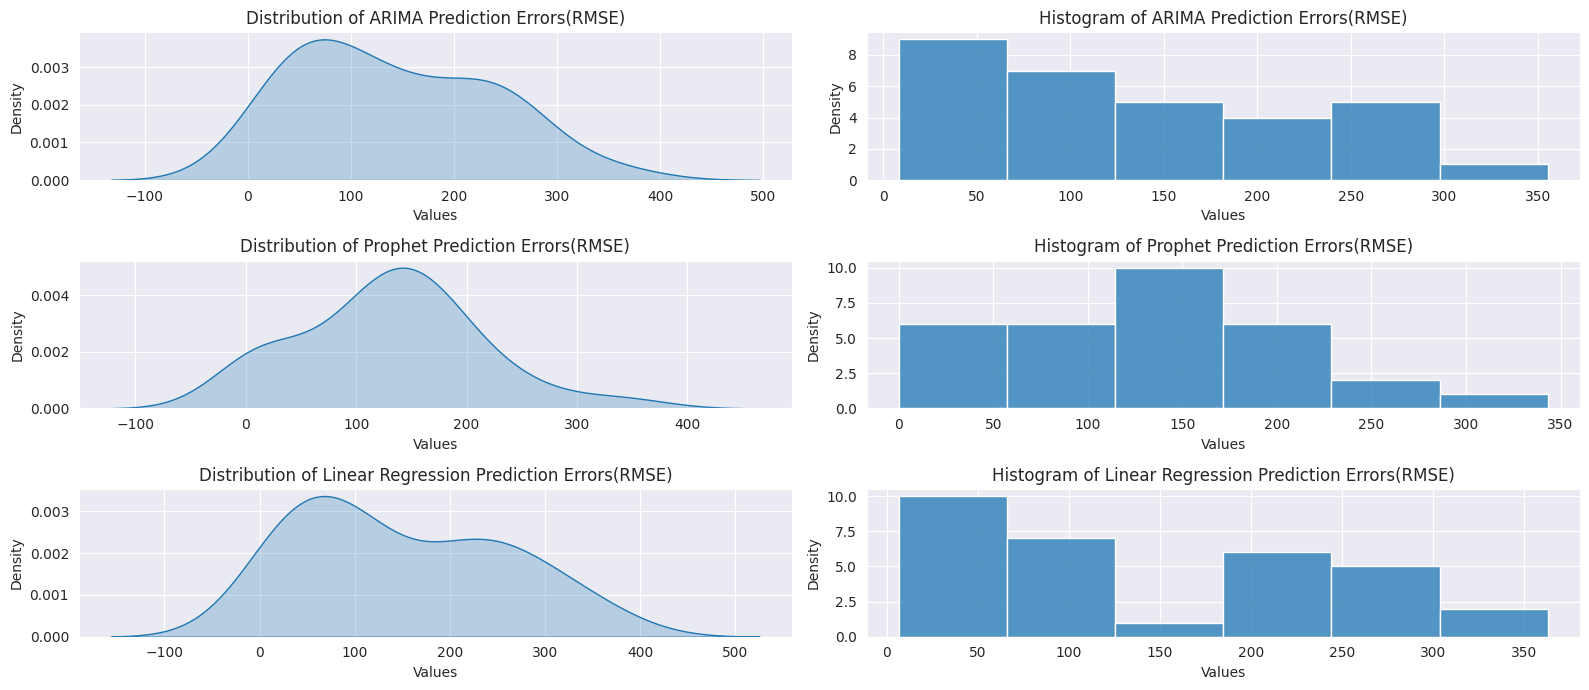

In [114]:

fig, axes = plt.subplots(3, 2, figsize=(16, 7))  # 3 rows, 2 columns


arima_errors = Calculate_Error_RMSE(arima_pred.values)
fbProphet_errors = Calculate_Error_RMSE(fb_pred.yhat.tail(len(test)).values)
lr_errors = Calculate_Error_RMSE(lr_pred)

# Plot the kdeplot on the first subplot
# Access the correct Axes object using indexing
sns.kdeplot(arima_errors, fill=True, ax=axes[0, 0])
axes[0, 0].set_title('Distribution of ARIMA Prediction Errors(RMSE)')
axes[0, 0].set_xlabel('Values')
axes[0, 0].set_ylabel('Density')

# Plot the histplot on the second subplot
# Access the correct Axes object using indexing
sns.histplot(arima_errors, ax=axes[0, 1])
axes[0, 1].set_title('Histogram of ARIMA Prediction Errors(RMSE)')
axes[0, 1].set_xlabel('Values')
axes[0, 1].set_ylabel('Density')

# ... (similarly for other plots)
sns.kdeplot(fbProphet_errors, fill=True, ax=axes[1, 0])
axes[1, 0].set_title('Distribution of Prophet Prediction Errors(RMSE)')
axes[1, 0].set_xlabel('Values')
axes[1, 0].set_ylabel('Density')

sns.histplot(fbProphet_errors, ax=axes[1, 1])
axes[1, 1].set_title('Histogram of Prophet Prediction Errors(RMSE)')
axes[1, 1].set_xlabel('Values')
axes[1, 1].set_ylabel('Density')

sns.kdeplot(lr_errors, fill=True, ax=axes[2, 0])
axes[2, 0].set_title('Distribution of Linear Regression Prediction Errors(RMSE)')
axes[2, 0].set_xlabel('Values')
axes[2, 0].set_ylabel('Density')

sns.histplot(lr_errors, ax=axes[2, 1])
axes[2, 1].set_title('Histogram of Linear Regression Prediction Errors(RMSE)')
axes[2, 1].set_xlabel('Values')
axes[2, 1].set_ylabel('Density')

plt.tight_layout()
plt.show()

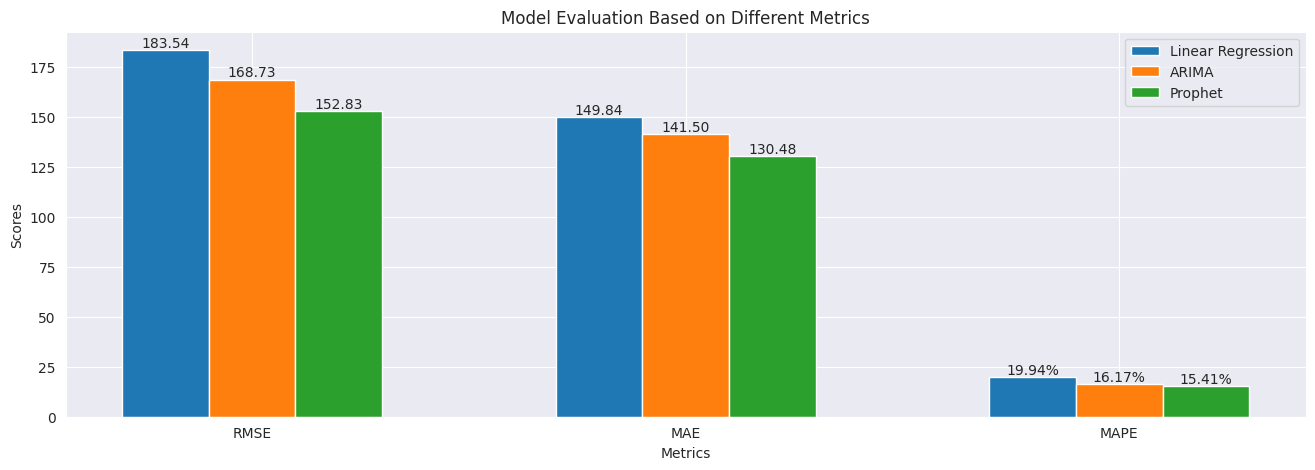

In [121]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error,root_mean_squared_error

# Data
models = ['Linear Regression', 'ARIMA', 'Prophet']
metrics = ['RMSE', 'MAE', 'MAPE']

lr_rmse = root_mean_squared_error(test['y'], lr_pred)
arima_rmse = root_mean_squared_error(test['y'], arima_pred)
fb_rmse = root_mean_squared_error(test['y'], fb_pred.yhat.values)

lr_mae = mean_absolute_error(test['y'], lr_pred)
arima_mae = mean_absolute_error(test['y'], arima_pred)
fb_mae = mean_absolute_error(test['y'], fb_pred.yhat.values)

lr_mape = mean_absolute_percentage_error(test['y'], lr_pred) * 100
arima_mape = mean_absolute_percentage_error(test['y'], arima_pred) * 100
fb_mape = mean_absolute_percentage_error(test['y'], fb_pred.yhat.values) * 100



values = {
    'Linear Regression': [lr_rmse,lr_mae,lr_mape],
    'ARIMA': [arima_rmse,arima_mae,arima_mape],
    'Prophet': [fb_rmse,fb_mae,fb_mape]
}

# Bar properties
x = np.arange(len(metrics))  # the label locations
width = 0.2  # the width of the bars
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Colors for bars

# Plotting
fig, ax = plt.subplots(figsize=(16, 5))
for i, model in enumerate(models):
    bars = ax.bar(x + i * width, values[model], width, label=model, color=colors[i])
    for j, bar in enumerate(bars):
        yval = bar.get_height()
        if metrics[j] == 'MAPE':
            ax.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}%', ha='center', va='bottom')
        else:
            ax.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom')

# Labels and formatting
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Model Evaluation Based on Different Metrics')
ax.set_xticks(x + width)
ax.set_xticklabels(metrics)
ax.legend()

# Show plot
plt.show()

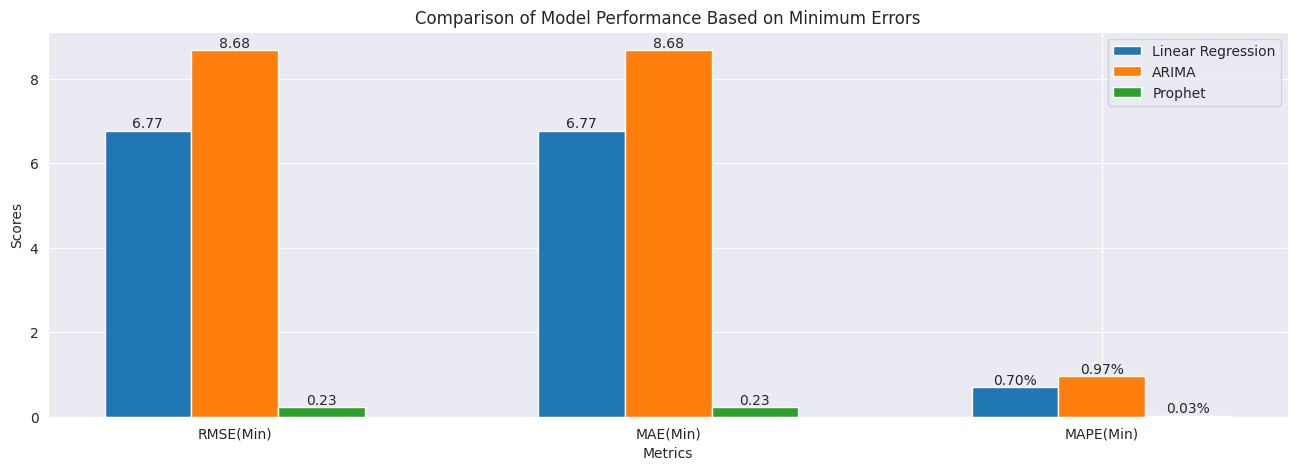

In [122]:
lr_Min_rmse = np.min(lr_errors)
arima_Min_rmse = np.min(arima_errors)
fb_Min_rmse = np.min(fbProphet_errors)

lr_Min_mae = np.min(Calculate_Error_MAE(lr_pred))
arima_Min_mae = np.min(Calculate_Error_MAE(arima_pred.values))
fb_Min_mae = np.min(Calculate_Error_MAE(fb_pred.yhat.values))

lr_Min_mape = np.min(Calculate_Error_MAPE(lr_pred))
arima_Min_mape = np.min(Calculate_Error_MAPE(arima_pred.values))
fb_Min_mape = np.min(Calculate_Error_MAPE(fb_pred.yhat.values))



# Data
models = ['Linear Regression', 'ARIMA', 'Prophet']
metrics = ['RMSE(Min)', 'MAE(Min)', 'MAPE(Min)']


values = {
    'Linear Regression': [lr_Min_rmse,lr_Min_mae,lr_Min_mape],
    'ARIMA': [arima_Min_rmse,arima_Min_mae,arima_Min_mape],
    'Prophet': [fb_Min_rmse,fb_Min_mae,fb_Min_mape]
}

# Bar properties
x = np.arange(len(metrics))  # the label locations
width = 0.2  # the width of the bars
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Colors for bars

# Plotting
fig, ax = plt.subplots(figsize=(16, 5))
for i, model in enumerate(models):
    bars = ax.bar(x + i * width, values[model], width, label=model, color=colors[i])
    for j, bar in enumerate(bars):
        yval = bar.get_height()
        if metrics[j] == 'MAPE(Min)':
            ax.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}%', ha='center', va='bottom')
        else:
            ax.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom')

# Labels and formatting
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Model Performance Based on Minimum Errors')
ax.set_xticks(x + width)
ax.set_xticklabels(metrics)
ax.legend()

# Show plot
plt.show()

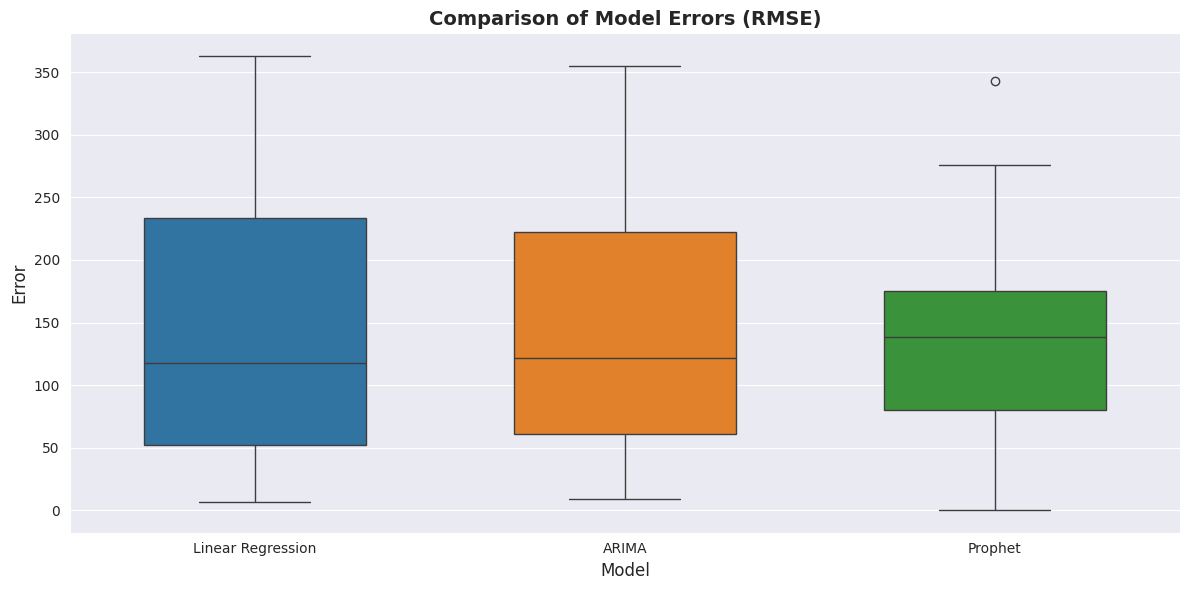

In [123]:
import pandas as pd
# Create a DataFrame
model_data = [
    ("Linear Regression", lr_errors),
    ("ARIMA", arima_errors),
    ("Prophet", fbProphet_errors),
]

# Convert model_data to DataFrame
model_data = pd.DataFrame(data=[(model, error) for model, errors in model_data for error in errors],
                          columns=['Model', 'Error'])

# Set Seaborn style
sns.set_style("darkgrid")

# Create the figure
plt.figure(figsize=(12, 6))

# Boxplot with custom colors
palette = ["#1f77b4", "#ff7f0e", "#2ca02c"]  # Custom color palette
sns.boxplot(x="Model", y="Error", data=model_data, palette=palette, width=0.6)


# Labels and title
plt.title("Comparison of Model Errors (RMSE)", fontsize=14, fontweight="bold")
plt.xlabel("Model", fontsize=12)
plt.ylabel("Error", fontsize=12)

# Adjust layout and show plot
plt.tight_layout()
plt.show()

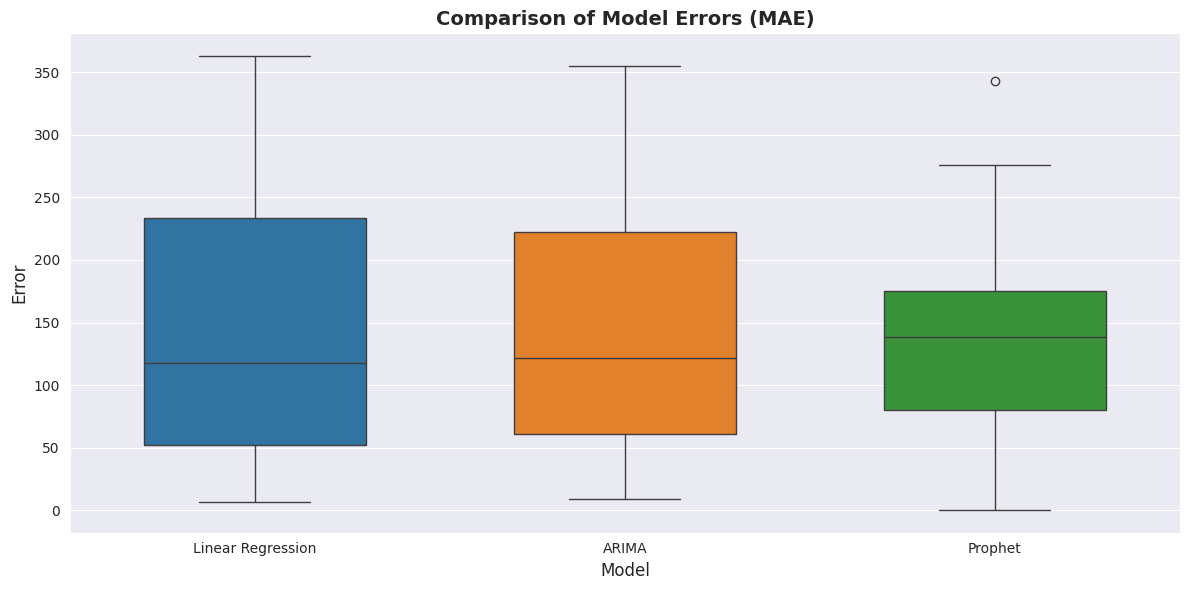

In [124]:
model_data = [
    ("Linear Regression", Calculate_Error_MAE(lr_pred)),
    ("ARIMA", Calculate_Error_MAE(arima_pred.values)),
    ("Prophet", Calculate_Error_MAE(fb_pred.yhat)),
]

# Convert model_data to DataFrame
model_data = pd.DataFrame(data=[(model, error) for model, errors in model_data for error in errors],
                          columns=['Model', 'Error'])

# Set Seaborn style
sns.set_style("darkgrid")

# Create the figure
plt.figure(figsize=(12, 6))

# Boxplot with custom colors
palette = ["#1f77b4", "#ff7f0e", "#2ca02c"]  # Custom color palette
sns.boxplot(x="Model", y="Error", data=model_data, palette=palette, width=0.6)


# Labels and title
plt.title("Comparison of Model Errors (MAE)", fontsize=14, fontweight="bold")
plt.xlabel("Model", fontsize=12)
plt.ylabel("Error", fontsize=12)

# Adjust layout and show plot
plt.tight_layout()
plt.show()

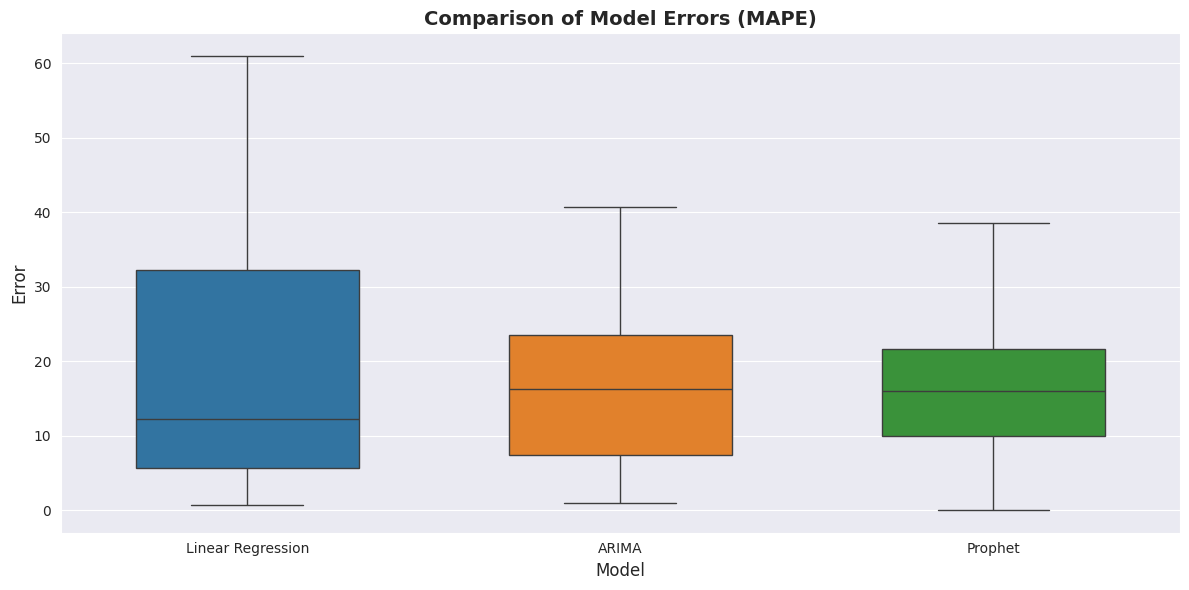

In [125]:
model_data = [
    ("Linear Regression", Calculate_Error_MAPE(lr_pred)),
    ("ARIMA", Calculate_Error_MAPE(arima_pred.values) ),
    ("Prophet",Calculate_Error_MAPE(fb_pred.yhat.values)),
]


# Convert model_data to DataFrame
model_data = pd.DataFrame(data=[(model, error) for model, errors in model_data for error in errors],
                          columns=['Model', 'Error'])

# Set Seaborn style
sns.set_style("darkgrid")

# Create the figure
plt.figure(figsize=(12, 6))

# Boxplot with custom colors
palette = ["#1f77b4", "#ff7f0e", "#2ca02c"]  # Custom color palette
sns.boxplot(x="Model", y="Error", data=model_data, palette=palette, width=0.6)


# Labels and title
plt.title("Comparison of Model Errors (MAPE)", fontsize=14, fontweight="bold")
plt.xlabel("Model", fontsize=12)
plt.ylabel("Error", fontsize=12)

# Adjust layout and show plot
plt.tight_layout()
plt.show()